In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh
import pickle as pkl

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

# the files are too big
#paths = paths[:420]

#df = pd.concat([pd.read_pickle(path) for path in tqdm(paths)])
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < np.inf*1024**2:
        try:
            with open(path, 'rb') as file:
                loaded_dict = pkl.load(file)
            loaded_dict['transpositions'].insert(0, 'complex_index0', loaded_dict['complex_index0'])
            loaded_dict['transpositions'].insert(1, 'complex_index1', loaded_dict['complex_index1'])
            loaded_dict['transpositions'].insert(2, 'complex_dim', loaded_dict['complex_dim'])
            loaded_dict['transpositions'].insert(3, 'complex_shape', [loaded_dict['complex_shape']]*len(loaded_dict['transpositions']))
            df.append(loaded_dict['transpositions'])

        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

print(f'There are {pd.isna(df['transposition']).sum()} empty transposition values in {len(df)} lines')
#df = df[~pd.isna(df['transposition'])]
df = df.join(df['transposition'].apply(lambda tr: tr.to_dict()).apply(pd.Series))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 15/15 [00:00<00:00, 51.02it/s]


There are 0 empty transposition values in 1770 lines
df.shape = (9808, 25)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,time,value,transposition,birth_relation_cell_similarity,birth_relation_index_similarity,...,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity,index 0,index 1,cell 0,cell 1,dim,type,switch
0,2025-06-18 16:08:54.773142,2025-06-18 16:08:54.804299,1,5,"(5,)",0.0517,0.108668,"<((1,),), ((2,),)>",1.0,1.0,...,1.0,1.0,1.0,0,1,"((1,),)","((2,),)",0,birth-unpaired,undefined
0,2025-06-18 16:08:54.773142,2025-06-18 16:08:54.804299,1,5,"(5,)",0.0517,0.108668,"<((1,),), ((2,),)>",1.0,1.0,...,1.0,1.0,1.0,1,2,"((3,),)","((0,),)",0,birth-birth,no switch
0,2025-06-18 16:08:54.773142,2025-06-18 16:08:54.804299,1,5,"(5,)",0.0517,0.108668,"<((1,),), ((2,),)>",1.0,1.0,...,1.0,1.0,1.0,1,2,"((0,),)","((1,),)",0,birth-birth,no switch
0,2025-06-18 16:08:54.773142,2025-06-18 16:08:54.804299,1,5,"(5,)",0.0517,0.108668,"<((1,),), ((2,),)>",1.0,1.0,...,1.0,1.0,1.0,4,5,"((1,),)","((4,),)",0,birth-birth,no switch
0,2025-06-18 16:08:54.773142,2025-06-18 16:08:54.804299,1,5,"(5,)",0.0517,0.108668,"<((1,),), ((2,),)>",1.0,1.0,...,1.0,1.0,1.0,3,4,"((2,),)","((5,),)",0,birth-birth,no switch


In [4]:
loaded_dict['transpositions']

,complex_index0,complex_index1,complex_dim,complex_shape,time,value,transposition,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,death_relation_index_similarity,poset_arc_cell_similarity,poset_arc_index_similarity,poset_node_cell_similarity,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity
0,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.008962,1.937986,"<((22,), (23,)), ((10,), (11,))>",0.857143,1.000000,0.785714,0.785714,0.626667,0.906250,0.9375,1.000000,0.808511,0.888889
1,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.011520,0.752268,"<((0,),), ((7,),)>",1.000000,0.857143,1.000000,0.777778,1.000000,0.846154,1.0000,0.878788,1.000000,0.826087
2,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.013031,1.109663,"<((17,), (18,)), ((3,), (4,))>",1.000000,0.733333,1.000000,0.777778,1.000000,0.818182,1.0000,0.878788,1.000000,0.787234
3,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.019551,0.860309,"<((1,),), ((26,),)>",1.000000,0.857143,1.000000,0.846154,1.000000,0.846154,1.0000,0.878788,1.000000,0.866667
4,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.022127,0.859897,"<((1,),), ((5,),)>",1.000000,0.857143,1.000000,0.846154,1.000000,0.791045,1.0000,0.878788,1.000000,0.826087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.990609,0.704821,"<((27,),), ((1,),)>",1.000000,0.769231,1.000000,0.785714,1.000000,0.791045,1.0000,0.878788,1.000000,0.777778
510,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.991802,1.448275,"<((14,), (15,)), ((9,), (10,))>",1.000000,0.769231,1.000000,0.851852,1.000000,0.846154,1.0000,0.878788,1.000000,0.818182
511,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.994217,0.704243,"<((18,),), ((1,),)>",1.000000,0.769231,1.000000,0.923077,1.000000,0.846154,1.0000,0.878788,1.000000,0.818182
512,2025-06-18 16:09:47.260962,2025-06-18 16:09:44.463081,1,"(32,)",0.996242,1.510292,"<((30,), (31,)), ((6,), (7,))>",1.000000,0.916667,1.000000,0.785714,1.000000,0.818182,1.0000,0.878788,1.000000,0.818182


In [5]:
df.columns

Index(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n',
       'complex_shape', 'time', 'value', 'transposition',
       'birth_relation_cell_similarity', 'birth_relation_index_similarity',
       'death_relation_cell_similarity', 'death_relation_index_similarity',
       'poset_arc_cell_similarity', 'poset_arc_index_similarity',
       'poset_node_cell_similarity', 'poset_node_index_similarity',
       'relation_cell_similarity', 'relation_index_similarity', 'index 0',
       'index 1', 'cell 0', 'cell 1', 'dim', 'type', 'switch'],
      dtype='object')

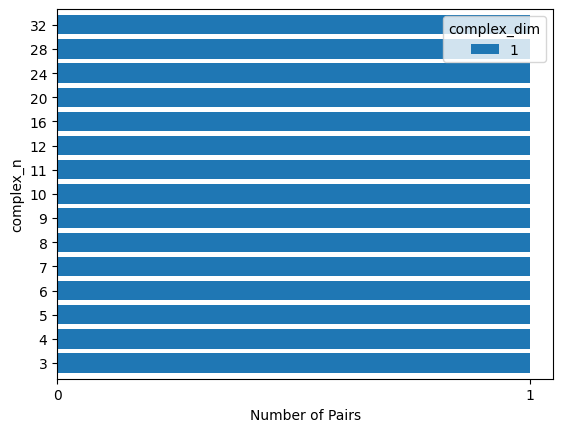

In [6]:
df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n']
           )['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().pivot_table(columns='complex_dim', index='complex_n', values='complex_index0').fillna(0).astype(int).plot(kind='barh', width=0.8)

plt.xlabel('Number of Pairs')
xticks, _ = plt.xticks()
xticks = np.unique(np.array(xticks).astype(int))
plt.xticks(xticks)

plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\;'
<>:19: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_56365/2076783452.py:19: SyntaxWarning: invalid escape sequence '\;'
  axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')


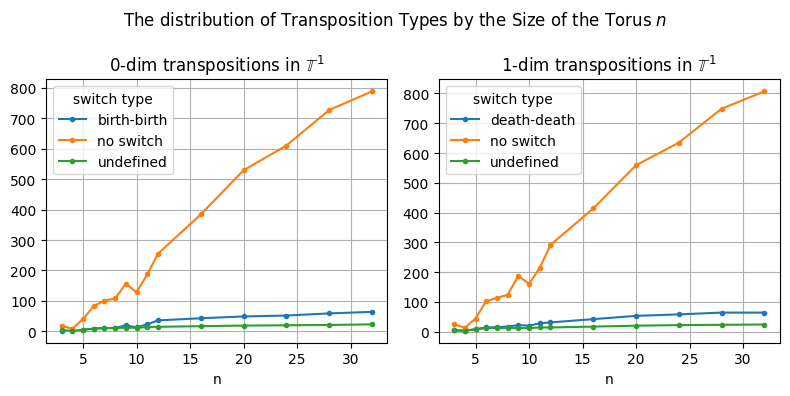

In [7]:
df_switch_types = df.copy()

df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
df_switch_types['switch type'] = df_switch_types.apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)

df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
df_switch_types = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
df_switch_types = df_switch_types.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1), squeeze=False)
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$')
for i, complex_dim in enumerate(complex_dims):
    for j, transposition_dim in enumerate(transposition_dims):
        try:
            df_switch_types[complex_dim][transposition_dim].plot(ax=axs[i, j], marker='.')
            axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
            axs[i, j].grid(True)
            axs[i, j].set_xlabel('n')
        except KeyError:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
plt.tight_layout()
